In [1]:
#Importing necessary libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16,ResNet50,MobileNet,InceptionV3,EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout, Input, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle

In [2]:
#Checking the version of Tensorflow and GPU
print("TensorFlow version:", tf.__version__)
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

TensorFlow version: 2.18.0
Num GPUs Available: 0


In [3]:
#Connecting Google Drive to the Colab environment
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#Listing the contents in My Drive location
!ls "/content/drive/My Drive"

'16-09-2018 GRADUATION PICS BE CSE UIT'
 20241101_181834.jpg
'260804180-193505 Debit Advice for Import Bills Charges Report-18-AUG-22.pdf'
 BOQ_569084.gsheet
'Certification Recommendations Profile Wise.gsheet'
'Closing letter Canara Bank 1.pdf'
'Colab Notebooks'
'Copy of How to Use GitHub.pptx'
 Dataset.zip
 Error_String_indices.jpg
'Krishna Aadhar.PDF'
'Krishna NSDC Registration.jpg'
'Krishna NSDC Reg.png'
'Krishna Raj Resume.docx'
 Krishna-Resume.pdf
 Molasses.xlsx
 Pandas_new_mentor.ipynb
'Session 2_ Creating a Database (V2).pptx'
'Srinivasan Certificate.pdf'
'Texila Images'
'Untitled spreadsheet.gsheet'
'ZF Rate Calculation.xlsx'


In [5]:
#Extracting the zip Dataset folder into individual folders
import zipfile
import os

zip_path = "/content/drive/My Drive/Dataset.zip"
extract_path = "/content/Dataset"  # Extract location

# Create directory if not exists
os.makedirs(extract_path, exist_ok=True)

# Extract the dataset
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Dataset extracted successfully!")


Dataset extracted successfully!


In [6]:
#Listing the contents inside the Dataset folder
!ls "/content/Dataset/images.cv_jzk6llhf18tm3k0kyttxz/data"


test  train  val


In [7]:
#Defining the dataset path
dataset_path = "/content/Dataset/images.cv_jzk6llhf18tm3k0kyttxz/data"


In [8]:
#Approach - 1 -Data Preprocessing and  Augmentation
# Training data with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [9]:
# Validation & Test data - Only Rescaling
val_test_datagen = ImageDataGenerator(rescale=1./255)


In [10]:
# Loading train, val, and test datasets
train_data = train_datagen.flow_from_directory(
    directory=f"{dataset_path}/train",
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical"
)

val_data = val_test_datagen.flow_from_directory(
    directory=f"{dataset_path}/val",
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical"
)

test_data = val_test_datagen.flow_from_directory(
    directory=f"{dataset_path}/test",
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical",
    shuffle=False
)

Found 6225 images belonging to 11 classes.
Found 1092 images belonging to 11 classes.
Found 3187 images belonging to 11 classes.


In [11]:
print(train_data.class_indices)

{'animal fish': 0, 'animal fish bass': 1, 'fish sea_food black_sea_sprat': 2, 'fish sea_food gilt_head_bream': 3, 'fish sea_food hourse_mackerel': 4, 'fish sea_food red_mullet': 5, 'fish sea_food red_sea_bream': 6, 'fish sea_food sea_bass': 7, 'fish sea_food shrimp': 8, 'fish sea_food striped_red_mullet': 9, 'fish sea_food trout': 10}


In [ ]:
# Loading VGG16 model without top layers (Fully Connected Layers)
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

#Freezing the base model layers
base_model.trainable = False

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [ ]:
# Adding custom classification layers
x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
output_layer = Dense(11, activation='softmax')(x)

In [ ]:
#Creating the Model
model = Model(inputs=base_model.input, outputs=output_layer)

In [ ]:
#Compiling the Model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
#Model Summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 256)                 │       6,422,784 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 21,171,787 (80.76 MB)

 Trainable params: 6,457,099 (24.63 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
#Defining Early Stopping to prevent Overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

#Training the model
history = model.fit(train_data,
                    epochs = 20,
                    validation_data = val_data,
                    callbacks = [early_stopping],
                    verbose = 2)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
195/195 - 125s - 640ms/step - accuracy: 0.3279 - loss: 1.9295 - val_accuracy: 0.7079 - val_loss: 1.2601
Epoch 2/20
195/195 - 93s - 475ms/step - accuracy: 0.5259 - loss: 1.3847 - val_accuracy: 0.8233 - val_loss: 0.8224
Epoch 3/20
195/195 - 92s - 472ms/step - accuracy: 0.6132 - loss: 1.1202 - val_accuracy: 0.8846 - val_loss: 0.6186
Epoch 4/20
195/195 - 93s - 476ms/step - accuracy: 0.6827 - loss: 0.9334 - val_accuracy: 0.9176 - val_loss: 0.4488
Epoch 5/20
195/195 - 145s - 742ms/step - accuracy: 0.7232 - loss: 0.8162 - val_accuracy: 0.9167 - val_loss: 0.3625
Epoch 6/20
195/195 - 92s - 469ms/step - accuracy: 0.7574 - loss: 0.7228 - val_accuracy: 0.9240 - val_loss: 0.3082
Epoch 7/20
195/195 - 92s - 471ms/step - accuracy: 0.7920 - loss: 0.6313 - val_accuracy: 0.9460 - val_loss: 0.2444
Epoch 8/20
195/195 - 91s - 466ms/step - accuracy: 0.8069 - loss: 0.5829 - val_accuracy: 0.9377 - val_loss: 0.2345
Epoch 9/20
195/195 - 95s - 487ms/step - accuracy: 0.8169 - loss: 0.5335 - val_accuracy

In [ ]:
#Evaluating the Test data
test_loss,test_acc = model.evaluate(test_data)
print(f"Test Accuracy:{test_acc*100:.2f}%")

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


100/100 ━━━━━━━━━━━━━━━━━━━━ 28s 283ms/step - accuracy: 0.9848 - loss: 0.0615
Test Accuracy:98.53%


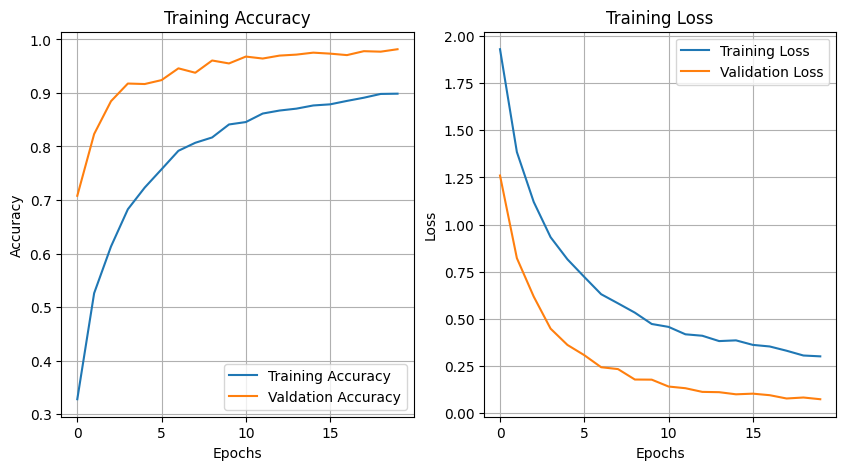

In [ ]:
#Plotting the training and validation accuracy
plt.figure(figsize=(10,5))
#Accuracy plot
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'],label = 'Training Accuracy')
plt.plot(history.history['val_accuracy'],label = 'Valdation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Training Accuracy')
plt.grid(True)

#Loss Plot
plt.subplot(1,2,2)
plt.plot(history.history['loss'],label='Training Loss')
plt.plot(history.history['val_loss'],label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc = 'upper right')
plt.title('Training Loss')
plt.grid(True)
plt.show()


In [ ]:
#Getting predictions
y_pred = model.predict(test_data)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_data.classes

#Getting Class Labels
class_labels = list(test_data.class_indices.keys())

#Generating Classification Report
report = classification_report(y_true, y_pred_classes, target_names=class_labels)
print(report)

100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 196ms/step
                                  precision    recall  f1-score   support

                     animal fish       0.98      1.00      0.99       520
                animal fish bass       0.00      0.00      0.00        13
   fish sea_food black_sea_sprat       0.99      0.98      0.99       298
   fish sea_food gilt_head_bream       0.99      1.00      1.00       305
   fish sea_food hourse_mackerel       0.98      0.98      0.98       286
        fish sea_food red_mullet       0.97      0.98      0.98       291
     fish sea_food red_sea_bream       1.00      0.99      0.99       273
          fish sea_food sea_bass       1.00      0.98      0.99       327
            fish sea_food shrimp       0.99      1.00      1.00       289
fish sea_food striped_red_mullet       0.96      0.98      0.97       293
             fish sea_food trout       1.00      0.99      0.99       292

                        accuracy                           0.99   

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
#Saving the moedl in .pkl file
with open("fish_classification_model.pkl","wb") as file:
  pickle.dump(model,file)
print("Model Saved as fish_classification_model.pkl")

Model Saved as fish_classification_model.pkl


In [ ]:
os.listdir('/content')

['.config', 'fish_classification_model.pkl', 'drive', 'Dataset', 'sample_data']

In [ ]:
from google.colab import files
files.download('/content/fish_classification_model.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
*************************************************************

In [ ]:
#Pre-Trained Model 2 : ResNet50
#Loading ResNEt50 Base Model
base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

In [ ]:
# Step 1: Freeze all layers in the base model
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
# Step 2: Unfreeze only the last 50 layers
for layer in base_model.layers[-50:]:
    layer.trainable = True

In [ ]:
#Adding Custom Top layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
out = Dense(11, activation='softmax')(x)

In [ ]:
#Creating the Model
model = Model(inputs=base_model.input, outputs=out)

In [ ]:
#Compiling the Model
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 24,642,443 (94.00 MB)

 Trainable params: 18,005,259 (68.68 MB)

 Non-trainable params: 6,637,184 (25.32 MB)

In [ ]:
#Training the model
history = model.fit(train_data,
                    epochs = 20,
                    validation_data = val_data,
                    verbose = 2)

Epoch 1/20
195/195 - 89s - 458ms/step - accuracy: 0.4930 - loss: 1.4336 - val_accuracy: 0.2912 - val_loss: 2.5912
Epoch 2/20
195/195 - 91s - 468ms/step - accuracy: 0.5133 - loss: 1.3643 - val_accuracy: 0.2995 - val_loss: 4.5067
Epoch 3/20
195/195 - 86s - 441ms/step - accuracy: 0.5549 - loss: 1.2724 - val_accuracy: 0.2775 - val_loss: 5.6700
Epoch 4/20
195/195 - 88s - 451ms/step - accuracy: 0.5871 - loss: 1.1779 - val_accuracy: 0.1712 - val_loss: 22.6327
Epoch 5/20
195/195 - 89s - 458ms/step - accuracy: 0.6209 - loss: 1.0887 - val_accuracy: 0.2253 - val_loss: 6.5943
Epoch 6/20
195/195 - 87s - 449ms/step - accuracy: 0.6358 - loss: 1.0230 - val_accuracy: 0.4167 - val_loss: 3.3012
Epoch 7/20
195/195 - 87s - 446ms/step - accuracy: 0.6790 - loss: 0.9375 - val_accuracy: 0.6484 - val_loss: 1.2955
Epoch 8/20
195/195 - 85s - 438ms/step - accuracy: 0.7096 - loss: 0.8306 - val_accuracy: 0.3828 - val_loss: 4.0714
Epoch 9/20
195/195 - 87s - 447ms/step - accuracy: 0.7314 - loss: 0.7811 - val_accuracy:

In [ ]:
# Evaluate Model
test_loss, test_acc = model.evaluate(test_data)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 117ms/step - accuracy: 0.8082 - loss: 0.6521
Test Accuracy: 82.37%


In [ ]:
#Classification Report
y_pred = model.predict(test_data)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_data.classes

class_labels = list(test_data.class_indices.keys())

report = classification_report(y_true, y_pred_classes, target_names=class_labels)
print(report)

100/100 ━━━━━━━━━━━━━━━━━━━━ 16s 128ms/step
                                  precision    recall  f1-score   support

                     animal fish       0.91      0.96      0.93       520
                animal fish bass       0.00      0.00      0.00        13
   fish sea_food black_sea_sprat       1.00      0.47      0.64       298
   fish sea_food gilt_head_bream       0.99      0.49      0.65       305
   fish sea_food hourse_mackerel       0.89      0.92      0.91       286
        fish sea_food red_mullet       0.90      0.87      0.89       291
     fish sea_food red_sea_bream       0.93      0.82      0.87       273
          fish sea_food sea_bass       0.79      0.92      0.85       327
            fish sea_food shrimp       0.87      0.93      0.90       289
fish sea_food striped_red_mullet       0.75      0.80      0.77       293
             fish sea_food trout       0.56      1.00      0.71       292

                        accuracy                           0.82   

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


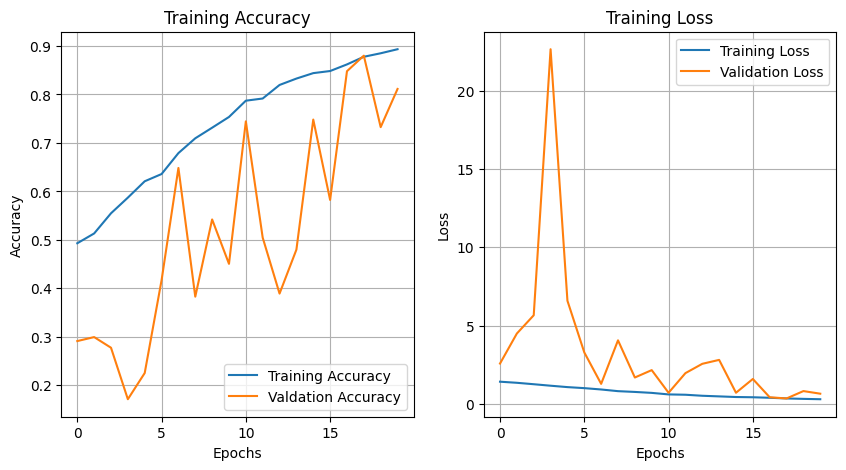

In [ ]:
#Plotting the training and validation accuracy
plt.figure(figsize=(10,5))
#Accuracy plot
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'],label = 'Training Accuracy')
plt.plot(history.history['val_accuracy'],label = 'Valdation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Training Accuracy')
plt.grid(True)

#Loss Plot
plt.subplot(1,2,2)
plt.plot(history.history['loss'],label='Training Loss')
plt.plot(history.history['val_loss'],label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc = 'upper right')
plt.title('Training Loss')
plt.grid(True)
plt.show()


In [ ]:
***************************************************************************************************

In [ ]:
#Pre-Trained Model - MobileNet
#Data Augumentation - Changing slightly from previous as MobileNet is lightweight
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range = 15, #Changed from 20% to 15%
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    shear_range = 0.1,
    zoom_range = 0.15,
    horizontal_flip = True,
    fill_mode = 'nearest'
)

In [ ]:
# Validation & Test data - Only Rescaling
val_test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
# Loading train, val, and test datasets
train_data = train_datagen.flow_from_directory(
    directory=f"{dataset_path}/train",
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical"
)

val_data = val_test_datagen.flow_from_directory(
    directory=f"{dataset_path}/val",
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical"
)

test_data = val_test_datagen.flow_from_directory(
    directory=f"{dataset_path}/test",
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical",
    shuffle=False
)

Found 6225 images belonging to 11 classes.
Found 1092 images belonging to 11 classes.
Found 3187 images belonging to 11 classes.


In [ ]:
#Loading base model without top layer
base_model = MobileNet(weights='imagenet',include_top=False,input_shape=(224,224,3))

17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
#Freezing the base layers
base_model.trainable = False

In [ ]:
#Adding custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512,activation='relu')(x)
x = Dense(256,activation='relu')(x)
x = Dropout(0.3)(x) #Since MobileNet has Batch Normalization reducing the Dropout to 0.3
out = Dense(11,activation='softmax')(x)

In [ ]:
#Creating the Model
model = Model(inputs=base_model.input,outputs=out)

In [ ]:
#Compiling the Model
model.compile(optimizer=Adam(learning_rate=0.0001),loss='categorical_crossentropy',metrics=['accuracy'])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1 (Conv2D)                       │ (None, 112, 112, 32)        │             864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_bn (BatchNormalization)        │ (None, 112, 112, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_relu (ReLU)                    │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1 (DepthwiseConv2D)          │ (None, 112, 112, 32)        │             288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_bn (BatchNormalization)    │ (None, 112, 112, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_relu (ReLU)                │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1 (Conv2D)                   │ (None, 112, 112, 64)        │           2,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_bn (BatchNormalization)    │ (None, 112, 112, 64)        │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_relu (ReLU)                │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pad_2 (ZeroPadding2D)           │ (None, 113, 113, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2 (DepthwiseConv2D)          │ (None, 56, 56, 64)          │             576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_bn (BatchNormalization)    │ (None, 56, 56, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_relu (ReLU)                │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2 (Conv2D)                   │ (None, 56, 56, 128)         │           8,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_bn (BatchNormalization)    │ (None, 56, 56, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_relu (ReLU)                │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3 (DepthwiseConv2D)          │ (None, 56, 56, 128)         │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_bn (BatchNormalization)    │ (None, 56, 56, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_relu (ReLU)                │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_3 (Conv2D)                   │ (None, 56, 56, 128)         │          16,384 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 3,887,819 (14.83 MB)

 Trainable params: 658,955 (2.51 MB)

 Non-trainable params: 3,228,864 (12.32 MB)

In [ ]:
#Training the model
history = model.fit(train_data,
                    validation_data = val_data,
                    epochs = 10,
                    steps_per_epoch = len(train_data), #Ensures full dataset coverage
                    validation_steps = len(val_data),
                    verbose = 2)

Epoch 1/10
195/195 - 83s - 427ms/step - accuracy: 0.9945 - loss: 0.0226 - val_accuracy: 0.9927 - val_loss: 0.0186
Epoch 2/10
195/195 - 74s - 381ms/step - accuracy: 0.9947 - loss: 0.0203 - val_accuracy: 0.9954 - val_loss: 0.0140
Epoch 3/10
195/195 - 96s - 492ms/step - accuracy: 0.9966 - loss: 0.0178 - val_accuracy: 0.9954 - val_loss: 0.0112
Epoch 4/10


KeyboardInterrupt: 

In [ ]:
#Evaluating Test Accuracy
test_loss,test_acc = model.evaluate(test_data)
print(f"Test Accuracy:{test_acc*100:.2f}%")

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 79ms/step - accuracy: 0.9968 - loss: 0.0124
Test Accuracy:99.62%


In [ ]:
#Saving the moedl in .pkl file
with open("fish_classification_model_MobileNet.pkl","wb") as file:
  pickle.dump(model,file)
print("Model Saved as fish_classification_model_MobileNet.pkl")

Model Saved as fish_classification_model_MobileNet.pkl


In [ ]:
os.listdir('/content')

['.config',
 'fish_classification_model_MobileNet.pkl',
 'Dataset',
 'drive',
 'sample_data']

In [ ]:
from google.colab import files
files.download('/content/fish_classification_model_MobileNet.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#Classification Report
y_pred = model.predict(test_data)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_data.classes

class_labels = list(test_data.class_indices.keys())

report = classification_report(y_true, y_pred_classes, target_names=class_labels)
print(report)

100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 83ms/step
                                  precision    recall  f1-score   support

                     animal fish       0.99      1.00      1.00       520
                animal fish bass       1.00      0.77      0.87        13
   fish sea_food black_sea_sprat       1.00      1.00      1.00       298
   fish sea_food gilt_head_bream       1.00      0.99      1.00       305
   fish sea_food hourse_mackerel       0.99      1.00      0.99       286
        fish sea_food red_mullet       1.00      1.00      1.00       291
     fish sea_food red_sea_bream       1.00      1.00      1.00       273
          fish sea_food sea_bass       0.99      1.00      1.00       327
            fish sea_food shrimp       1.00      1.00      1.00       289
fish sea_food striped_red_mullet       1.00      0.99      0.99       293
             fish sea_food trout       1.00      1.00      1.00       292

                        accuracy                           1.00    

In [ ]:
***************************************************************************************************

In [ ]:
#Pre-Trained Model - Inception V3
#Data Augumentation

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)


In [ ]:
#Loading the data
train_data = train_datagen.flow_from_directory(
    directory=f"{dataset_path}/train",
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical"
)

test_data = test_datagen.flow_from_directory(
    directory=f"{dataset_path}/test",
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical",
    shuffle=False
)

val_data = val_datagen.flow_from_directory(
    directory=f"{dataset_path}/val",
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical"
)

Found 6225 images belonging to 11 classes.
Found 3187 images belonging to 11 classes.
Found 1092 images belonging to 11 classes.


In [ ]:
#Loading InceptionV3 Model into the base layers
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
#Freezing the base layers
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
# Adding custom classification layers - Since InceptionV3 is complex model used two dropouts to avoid overfitting
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.4)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
output_layer = Dense(11, activation='softmax')(x)

In [ ]:
#Defining the model
model = Model(inputs=base_model.input, outputs=output_layer)

In [ ]:
#Compiling the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
#Model summary
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 111, 111, 32)   │            864 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 111, 111, 32)   │             96 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 111, 111, 32)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 109, 109, 32)   │          9,216 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 109, 109, 32)   │             96 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 109, 109, 32)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 109, 109, 64)   │         18,432 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 109, 109, 64)   │            192 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 109, 109, 64)   │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 54, 54, 64)     │              0 │ activation_2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 54, 54, 80)     │          5,120 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 54, 54, 80)     │            240 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 54, 54, 80)     │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 52, 52, 192)    │        138,240 │ activation_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 52, 52, 192)    │            576 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├──────────────────────

 Total params: 22,986,027 (87.68 MB)

 Trainable params: 1,183,243 (4.51 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [ ]:
#Training the model
history = model.fit(train_data,
                    epochs = 10,
                    validation_data = val_data,
                    steps_per_epoch = len(train_data),
                    validation_steps = len(val_data),
                    verbose = 2)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
195/195 - 114s - 586ms/step - accuracy: 0.5303 - loss: 1.3982 - val_accuracy: 0.8745 - val_loss: 0.5109
Epoch 2/10
195/195 - 114s - 584ms/step - accuracy: 0.7881 - loss: 0.6388 - val_accuracy: 0.9011 - val_loss: 0.3355
Epoch 3/10
195/195 - 78s - 401ms/step - accuracy: 0.8464 - loss: 0.4656 - val_accuracy: 0.9240 - val_loss: 0.2478
Epoch 4/10
195/195 - 82s - 420ms/step - accuracy: 0.8861 - loss: 0.3580 - val_accuracy: 0.9423 - val_loss: 0.1969
Epoch 5/10
195/195 - 84s - 431ms/step - accuracy: 0.8903 - loss: 0.3291 - val_accuracy: 0.9350 - val_loss: 0.2049
Epoch 6/10
195/195 - 79s - 403ms/step - accuracy: 0.9051 - loss: 0.2854 - val_accuracy: 0.9551 - val_loss: 0.1388
Epoch 7/10
195/195 - 79s - 407ms/step - accuracy: 0.9150 - loss: 0.2564 - val_accuracy: 0.9560 - val_loss: 0.1407
Epoch 8/10
195/195 - 79s - 405ms/step - accuracy: 0.9200 - loss: 0.2344 - val_accuracy: 0.9661 - val_loss: 0.1040
Epoch 9/10
195/195 - 83s - 427ms/step - accuracy: 0.9279 - loss: 0.2084 - val_accuracy

In [ ]:
# Evaluating the model on test data
test_loss, test_acc = model.evaluate(test_data)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


100/100 ━━━━━━━━━━━━━━━━━━━━ 17s 174ms/step - accuracy: 0.9797 - loss: 0.0755
Test Accuracy: 97.62%


In [ ]:
# Predicting labels
y_pred = np.argmax(model.predict(test_data), axis=1)
y_true = test_data.classes

# Classification Report
print(classification_report(y_true, y_pred, target_names=test_data.class_indices.keys()))

100/100 ━━━━━━━━━━━━━━━━━━━━ 19s 127ms/step
                                  precision    recall  f1-score   support

                     animal fish       0.97      1.00      0.98       520
                animal fish bass       0.00      0.00      0.00        13
   fish sea_food black_sea_sprat       1.00      0.96      0.98       298
   fish sea_food gilt_head_bream       0.99      0.98      0.99       305
   fish sea_food hourse_mackerel       0.97      0.99      0.98       286
        fish sea_food red_mullet       0.96      0.99      0.97       291
     fish sea_food red_sea_bream       0.99      0.99      0.99       273
          fish sea_food sea_bass       0.95      0.97      0.96       327
            fish sea_food shrimp       1.00      1.00      1.00       289
fish sea_food striped_red_mullet       0.96      0.90      0.93       293
             fish sea_food trout       0.98      1.00      0.99       292

                        accuracy                           0.98   

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


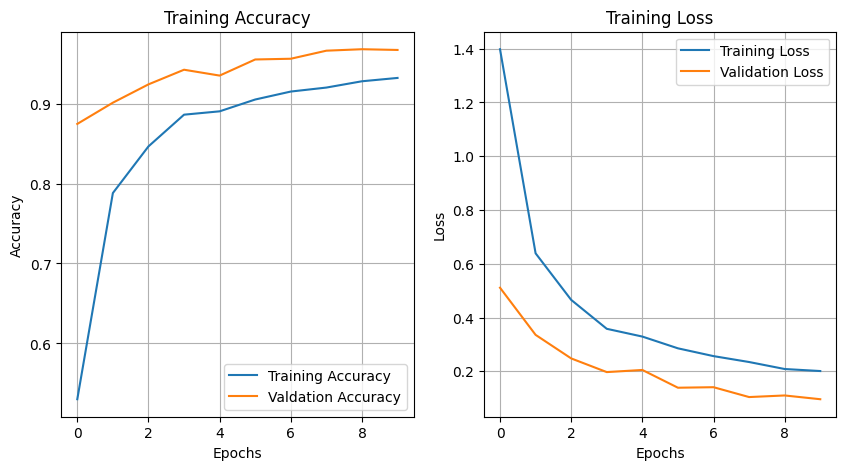

In [ ]:
#Plotting the training and validation accuracy
plt.figure(figsize=(10,5))
#Accuracy plot
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'],label = 'Training Accuracy')
plt.plot(history.history['val_accuracy'],label = 'Valdation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Training Accuracy')
plt.grid(True)

#Loss Plot
plt.subplot(1,2,2)
plt.plot(history.history['loss'],label='Training Loss')
plt.plot(history.history['val_loss'],label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc = 'upper right')
plt.title('Training Loss')
plt.grid(True)
plt.show()


In [ ]:
*********************************************************************************************

In [ ]:
#Pre-Trained Model - EfficientNetB0
#Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
#Loading the data
train_data = train_datagen.flow_from_directory(
    directory=f"{dataset_path}/train",
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical"
)
test_data = test_datagen.flow_from_directory(
    directory=f"{dataset_path}/test",
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical"
)
val_data = val_datagen.flow_from_directory(
    directory=f"{dataset_path}/val",
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical"
)

Found 6225 images belonging to 11 classes.
Found 3187 images belonging to 11 classes.
Found 1092 images belonging to 11 classes.


In [ ]:
#Loading the Model EfficientNetB0
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

#Freezing the base layers
base_model.trainable = True

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
#Adding Custom layers on the base_model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.4)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
output_layer = Dense(11, activation='softmax')(x)

In [ ]:
#Creating the Model
model = Model(inputs=base_model.input, outputs=output_layer)

In [ ]:
#Compiling the Model
model.compile(optimizer=Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
#Model Summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 224, 224, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 224, 224, 3)    │              7 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 225, 225, 3)    │              0 │ rescaling_1[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 112, 112, 32)   │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 112, 112, 32)   │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 112, 112, 32)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 112, 112, 32)   │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 112, 112, 32)   │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 112, 112, 32)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_expand    

 Total params: 4,839,598 (18.46 MB)

 Trainable params: 4,797,575 (18.30 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [ ]:
#Training the model
history = model.fit(train_data,
                    epochs = 10,
                    validation_data = val_data,
                    steps_per_epoch = len(train_data),
                    validation_steps = len(val_data),
                    verbose = 2)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
195/195 - 252s - 1s/step - accuracy: 0.1663 - loss: 2.3377 - val_accuracy: 0.0916 - val_loss: 2.3955
Epoch 2/10
195/195 - 156s - 801ms/step - accuracy: 0.3476 - loss: 2.0478 - val_accuracy: 0.2143 - val_loss: 2.1854
Epoch 3/10
195/195 - 139s - 712ms/step - accuracy: 0.4983 - loss: 1.6844 - val_accuracy: 0.2784 - val_loss: 1.8953
Epoch 4/10
195/195 - 142s - 730ms/step - accuracy: 0.6477 - loss: 1.3026 - val_accuracy: 0.2875 - val_loss: 1.9394
Epoch 5/10
195/195 - 98s - 501ms/step - accuracy: 0.7650 - loss: 0.9032 - val_accuracy: 0.2390 - val_loss: 1.9917
Epoch 6/10
195/195 - 141s - 722ms/step - accuracy: 0.8530 - loss: 0.5944 - val_accuracy: 0.6282 - val_loss: 1.0962
Epoch 7/10
195/195 - 99s - 507ms/step - accuracy: 0.9004 - loss: 0.4102 - val_accuracy: 0.6667 - val_loss: 0.9417
Epoch 8/10
195/195 - 137s - 702ms/step - accuracy: 0.9251 - loss: 0.2989 - val_accuracy: 0.9762 - val_loss: 0.1233
Epoch 9/10
195/195 - 144s - 740ms/step - accuracy: 0.9457 - loss: 0.2201 - val_accura

In [ ]:
#Evaluating the model
test_loss, test_acc = model.evaluate(test_data)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - accuracy: 0.9821 - loss: 0.0691
Test Accuracy: 98.24%


In [ ]:
#Classification report
y_pred = model.predict(test_data)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_data.classes

print(classification_report(y_true,y_pred_classes,target_names=test_data.class_indices.keys()))

100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 140ms/step
                                  precision    recall  f1-score   support

                     animal fish       0.16      0.16      0.16       520
                animal fish bass       0.00      0.00      0.00        13
   fish sea_food black_sea_sprat       0.08      0.08      0.08       298
   fish sea_food gilt_head_bream       0.11      0.10      0.10       305
   fish sea_food hourse_mackerel       0.08      0.08      0.08       286
        fish sea_food red_mullet       0.10      0.10      0.10       291
     fish sea_food red_sea_bream       0.08      0.09      0.08       273
          fish sea_food sea_bass       0.09      0.09      0.09       327
            fish sea_food shrimp       0.08      0.08      0.08       289
fish sea_food striped_red_mullet       0.08      0.08      0.08       293
             fish sea_food trout       0.08      0.08      0.08       292

                        accuracy                           0.10   

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


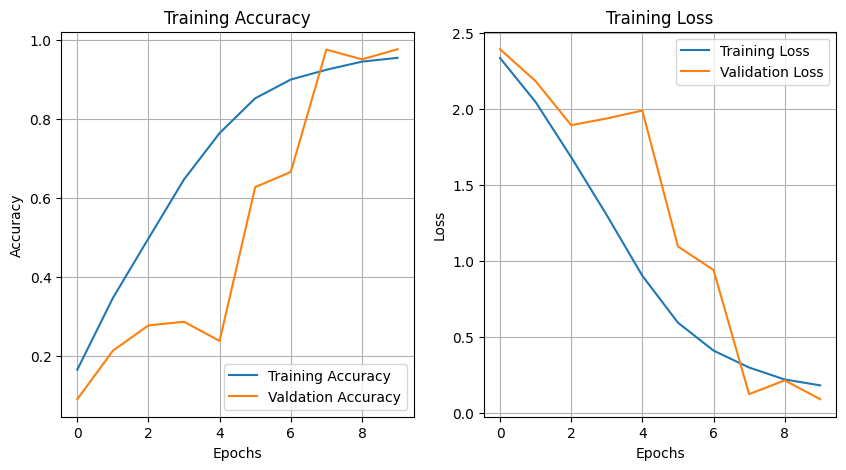

In [ ]:
#Plotting the training and validation accuracy
plt.figure(figsize=(10,5))
#Accuracy plot
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'],label = 'Training Accuracy')
plt.plot(history.history['val_accuracy'],label = 'Valdation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Training Accuracy')
plt.grid(True)

#Loss Plot
plt.subplot(1,2,2)
plt.plot(history.history['loss'],label='Training Loss')
plt.plot(history.history['val_loss'],label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc = 'upper right')
plt.title('Training Loss')
plt.grid(True)
plt.show()
